In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Bidirectional, LSTM, Reshape, GlobalAveragePooling1D, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Activation, GRU, Input, SeparableConv2D
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import tensorflow_io as tfio
import shutil
from tqdm import tqdm

SAMPLE_RATE = 16000

2025-05-24 13:25:50.105505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748093150.286801      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748093150.342824      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_uti

In [2]:
!pip install pyunpack
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 3.3 MB/s eta 0:00:00


In [3]:
import os
from pyunpack import Archive
import shutil
if not os.path.exists('/kaggle/working/train/'):
    os.makedirs('/kaggle/working/train/')
Archive('/kaggle/input/tensorflow-speech-recognition-challenge/train.7z').extractall('/kaggle/working/train/')

In [4]:
dataset_path = '/kaggle/working/train/train/audio'
data_dir = pathlib.Path(dataset_path)

commands = [cmd for cmd in tf.io.gfile.listdir(str(data_dir)) if cmd != '_background_noise_']
commands = np.sort(np.array(commands))
print('Команды:', commands)

Команды: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


In [5]:
def create_stratified_split(source_dir, target_dir, test_val_ratio=0.2, random_seed=42):
    os.makedirs(os.path.join(target_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'test'), exist_ok=True)
    
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir) or class_name == '_background_noise_':
            continue
            
        all_files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
        if not all_files:
            continue
            
        train_files, temp_files = train_test_split(
            all_files,
            test_size=test_val_ratio,
            random_state=random_seed
        )
        val_files, test_files = train_test_split(
            temp_files,
            test_size=0.5,
            random_state=random_seed
        )
        
        for folder in ['train', 'val', 'test']:
            os.makedirs(os.path.join(target_dir, folder, class_name), exist_ok=True)
        
        def copy_files(files, target_folder):
            for f in files:
                src = os.path.join(class_dir, f)
                dst = os.path.join(target_dir, target_folder, class_name, f)
                shutil.copy2(src, dst)
        
        copy_files(train_files, 'train')
        copy_files(val_files, 'val')
        copy_files(test_files, 'test')
        
        print(f'Class {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test')

In [6]:
SOURCE_DIR = '/kaggle/working/train/train/audio'
TARGET_DIR = '/kaggle/working/split_data'
    
create_stratified_split(SOURCE_DIR, TARGET_DIR)
    
total_train = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'train')))
total_val = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'val')))
total_test = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'test')))
    
print('\nИтоговые размеры:')
print(f'Train: {total_train} файлов')
print(f'Val: {total_val} файлов')
print(f'Test: {total_test} файлов')

Class happy: 1393 train, 174 val, 175 test
Class bird: 1384 train, 173 val, 174 test
Class nine: 1891 train, 236 val, 237 test
Class yes: 1901 train, 238 val, 238 test
Class six: 1895 train, 237 val, 237 test
Class dog: 1396 train, 175 val, 175 test
Class zero: 1900 train, 238 val, 238 test
Class seven: 1901 train, 238 val, 238 test
Class on: 1893 train, 237 val, 237 test
Class one: 1896 train, 237 val, 237 test
Class house: 1400 train, 175 val, 175 test
Class right: 1893 train, 237 val, 237 test
Class left: 1882 train, 235 val, 236 test
Class stop: 1904 train, 238 val, 238 test
Class eight: 1881 train, 235 val, 236 test
Class go: 1897 train, 237 val, 238 test
Class tree: 1386 train, 173 val, 174 test
Class five: 1885 train, 236 val, 236 test
Class wow: 1396 train, 174 val, 175 test
Class sheila: 1387 train, 173 val, 174 test
Class cat: 1386 train, 173 val, 174 test
Class up: 1900 train, 237 val, 238 test
Class down: 1887 train, 236 val, 236 test
Class marvin: 1396 train, 175 val, 175 

In [7]:
def add_random_noise(waveform, max_noise_level=0.02):
    noise_level = tf.random.uniform(shape=[], maxval=max_noise_level)
    noise = tf.random.normal(shape=tf.shape(waveform), mean=0.0, stddev=noise_level)
    return waveform + noise

In [8]:
def random_volume(waveform, min_factor=0.5, max_factor=1.5):
    factor = tf.random.uniform(shape=[], minval=min_factor, maxval=max_factor)
    return waveform * factor

In [9]:
def time_shift(waveform, shift_max=0.2):
    shift = int(tf.random.uniform([], -shift_max, shift_max) * SAMPLE_RATE)
    return tf.roll(waveform, shift, axis=0)

In [10]:
def stretch_time(waveform, min_rate=0.8, max_rate=1.25):
    rate = tf.random.uniform([], minval=min_rate, maxval=max_rate)

    def _np_stretch(wav_np, rate_np):
        import numpy as np
        orig_len = wav_np.shape[0]
        
        target_len = int(orig_len * float(rate_np))
        if target_len < 2:
            return wav_np
            
        x_old = np.linspace(0, orig_len - 1, orig_len)
        x_new = np.linspace(0, orig_len - 1, target_len)
        
        stretched = np.interp(x_new, x_old, wav_np).astype(np.float32)
        
        if stretched.shape[0] < orig_len:
            pad = np.zeros(orig_len - stretched.shape[0], dtype=np.float32)
            stretched = np.concatenate([stretched, pad])
        else:
            stretched = stretched[:orig_len]
        return stretched

    stretched = tf.numpy_function(_np_stretch, [waveform, rate], tf.float32)
    stretched.set_shape(waveform.shape)
    return stretched

In [11]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [12]:
def add_augmented_files(dataset_dir):
    for class_name in tqdm(os.listdir(dataset_dir), desc='Processing classes'):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir) or class_name == '_background_noise_':
            continue

        existing_files = set(os.listdir(class_dir))

        for filename in os.listdir(class_dir):
            if filename.startswith('aug_'):
                continue

            input_path = os.path.join(class_dir, filename)
            aug_filename = f'aug_{filename}'

            if aug_filename not in existing_files:
                audio_binary = tf.io.read_file(input_path)
                waveform = decode_audio(audio_binary)

                augmented = add_random_noise(
                    random_volume(
                        time_shift(
                            stretch_time(waveform)
                        )
                    )
                )

                aug_path = os.path.join(class_dir, aug_filename)
                wav_data = tf.audio.encode_wav(augmented[:, tf.newaxis], SAMPLE_RATE)
                tf.io.write_file(aug_path, wav_data)


dataset_path = '/kaggle/working/split_data/train'

add_augmented_files(dataset_path)

Processing classes:   0%|          | 0/30 [00:00<?, ?it/s]I0000 00:00:1748093262.811756      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748093262.812524      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Processing classes: 100%|██████████| 30/30 [04:17<00:00,  8.60s/it]


In [13]:
import tensorflow as tf
import pathlib

def load_split_dataset(base_dir):
    base = pathlib.Path(base_dir)

    train_files = [str(p) for p in base.joinpath('train').rglob('*.wav')]
    val_files   = [str(p) for p in base.joinpath('val').rglob('*.wav')]
    test_files  = [str(p) for p in base.joinpath('test').rglob('*.wav')]

    return train_files, val_files, test_files

In [14]:
TARGET_DIR = '/kaggle/working/split_data'
train_files, val_files, test_files = load_split_dataset(TARGET_DIR)

# Проверка размеров
print(f'Train files: {len(list(train_files))}')
print(f'Val files: {len(list(val_files))}')
print(f'Test files: {len(list(test_files))}')

Train files: 103528
Val files: 6471
Test files: 6486


In [15]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path,sep=os.path.sep)
  return parts[-2]

In [16]:
def get_waveform_and_label(file_path):
  label = get_label(file_path) 
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# MFCCDataset

In [17]:
def get_mfcc(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    
    stft = tf.signal.stft(waveform, frame_length=400, frame_step=160)
    spectrogram = tf.abs(stft)
    
    num_mel_bins = 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrogram.shape[-1],
        sample_rate=16000,
        lower_edge_hertz=80.0,
        upper_edge_hertz=7600.0
    )
    
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    num_mfcc = 13
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :num_mfcc]
    
    mfcc = mfcc[..., tf.newaxis]
    return mfcc

In [18]:
def get_mfcc_and_label_id(audio, label):
    mfcc_features = get_mfcc(audio)
    label_id = tf.argmax(label == commands)
    return mfcc_features, label_id

In [19]:
def preprocess_mfcc_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    return (
        files_ds
        .map(get_waveform_and_label,      num_parallel_calls=tf.data.AUTOTUNE)
        .map(get_mfcc_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
    )


In [20]:
spectrogram_mfcc_ds = preprocess_mfcc_dataset(train_files)
test_mfcc_ds = preprocess_mfcc_dataset(test_files)

In [21]:
batch_size = 128

train_mfcc_ds = (
    preprocess_mfcc_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_mfcc_ds = (
    preprocess_mfcc_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [22]:
for mfcc, _ in spectrogram_mfcc_ds.take(1):
    input_mfcc_shape = mfcc.shape
print('Размер входных данных для MFCC:', input_mfcc_shape)

num_labels = len(commands)

Размер входных данных для MFCC: (98, 13, 1)


# Dense

In [23]:
model_mfcc_dense = models.Sequential([
    layers.Input(shape=(input_mfcc_shape[0] * input_mfcc_shape[1],)),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
])

model_mfcc_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │       1,305,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,005,662 (7.65 MB)

 Trainable params: 2,002,078 (7.64 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [24]:
model_mfcc_dense.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [25]:
train_ds_dense = train_mfcc_ds.map(lambda x, y: (tf.reshape(x, [-1, input_mfcc_shape[0] * input_mfcc_shape[1]]), y))
val_ds_dense = val_mfcc_ds.map(lambda x, y: (tf.reshape(x, [-1, input_mfcc_shape[0] * input_mfcc_shape[1]]), y))
test_ds_dense = test_mfcc_ds.map(lambda x, y: (tf.reshape(x, [-1, input_mfcc_shape[0] * input_mfcc_shape[1]]), y))

In [26]:
EPOCHS = 200
history_dense = model_mfcc_dense.fit(
    train_ds_dense,
    validation_data=val_ds_dense,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
)

Epoch 1/200


I0000 00:00:1748093575.410975     108 service.cc:148] XLA service 0x7af9e8014440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748093575.411746     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748093575.411769     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748093575.790556     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 53/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0485 - loss: 3.7862

I0000 00:00:1748093578.674959     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


809/809 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.1847 - loss: 2.9260 - val_accuracy: 0.5616 - val_loss: 1.4250
Epoch 2/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4444 - loss: 1.8424 - val_accuracy: 0.6795 - val_loss: 1.0370
Epoch 3/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5297 - loss: 1.5600 - val_accuracy: 0.7441 - val_loss: 0.8313
Epoch 4/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5692 - loss: 1.4178 - val_accuracy: 0.7742 - val_loss: 0.7418
Epoch 5/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5966 - loss: 1.3211 - val_accuracy: 0.7838 - val_loss: 0.7071
Epoch 6/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6165 - loss: 1.2511 - val_accuracy: 0.7977 - val_loss: 0.6650
Epoch 7/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6368 - loss: 1.1890 - val_accuracy: 0.8065 - val_loss: 0.6172
Epoch 8/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6479 - loss: 1.1424 - val_accuracy: 0.81

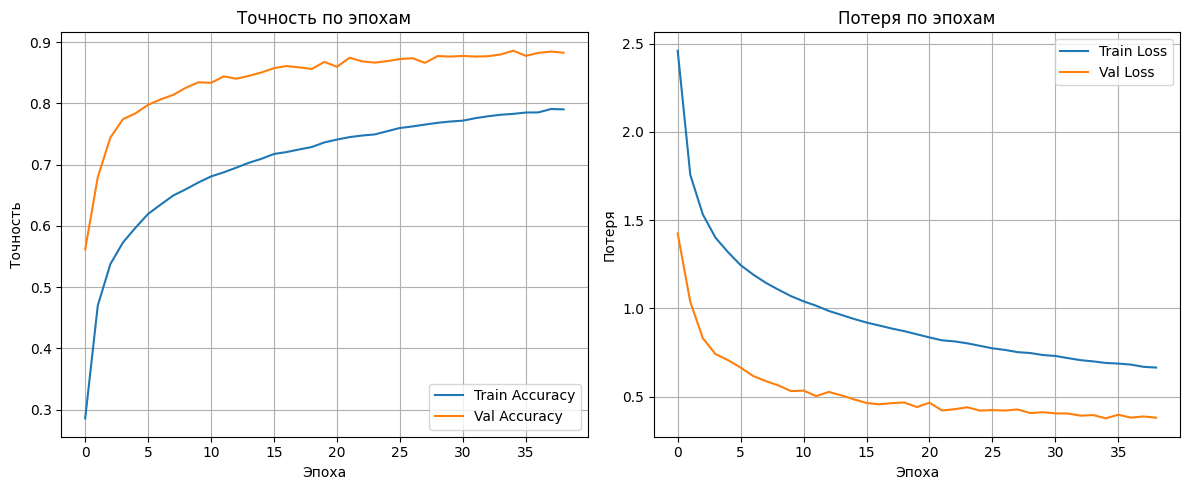

In [27]:
metrics = history_dense.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dense.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_dense.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_dense.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_dense.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mfcc_dense.png", dpi=300)
plt.show()

In [28]:
test_mfcc_audio = []
test_mfcc_labels = []

for audio, label in test_ds_dense:
  test_mfcc_audio.append(audio.numpy())
  test_mfcc_labels.append(label.numpy())

test_mfcc_audio = np.array(test_mfcc_audio)
test_mfcc_labels = np.array(test_mfcc_labels)

test_mfcc_audio = np.squeeze(test_mfcc_audio, axis=1)

In [29]:
y_pred = np.argmax(model_mfcc_dense.predict(test_mfcc_audio), axis=1)
y_true = test_mfcc_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Точность на тестовом наборе: 88%


In [30]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.8793    0.8895    0.8844       172
        bird     0.9444    0.8793    0.9107       174
         cat     0.9231    0.8966    0.9096       174
         dog     0.8808    0.7600    0.8160       175
        down     0.8069    0.7966    0.8017       236
       eight     0.8711    0.9449    0.9065       236
        five     0.9378    0.8305    0.8809       236
        four     0.9509    0.8950    0.9221       238
          go     0.6832    0.7521    0.7160       238
       happy     0.9486    0.9486    0.9486       175
       house     0.9609    0.9829    0.9718       175
        left     0.9000    0.8771    0.8884       236
      marvin     0.8989    0.9143    0.9065       175
        nine     0.8616    0.8143    0.8373       237
          no     0.7924    0.7857    0.7890       238
         off     0.8653    0.8983    0.8815       236
          on     0.8855    0.8481    0.8664       237
         one     0.8178    

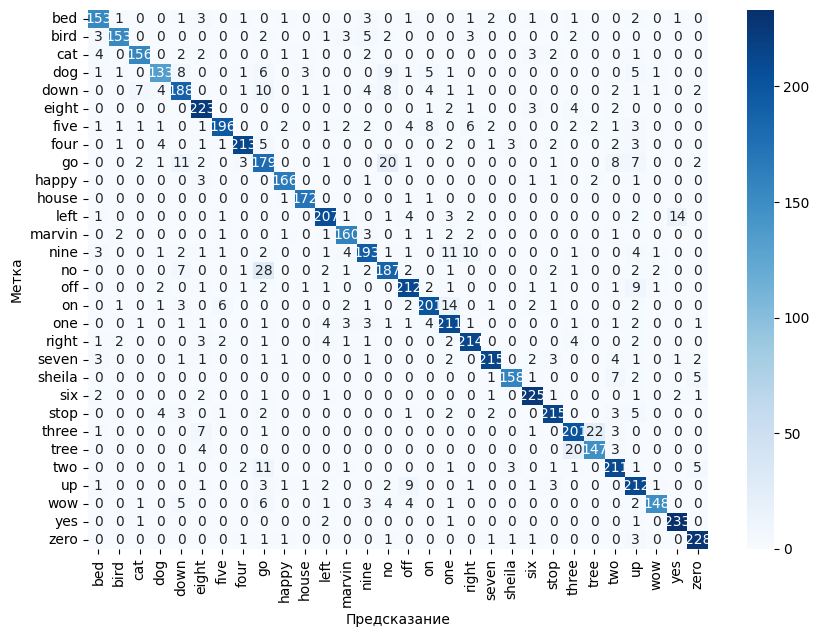

In [31]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mfcc_dense.png", dpi=300)
plt.show()

In [32]:
model_mfcc_dense.save("mfcc_dense.keras")

# CNNLight

In [33]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_mfcc_ds.map(map_func=lambda spec, label: spec))

In [34]:
model_mfcc_cnn_light = models.Sequential([
    layers.Input(shape=input_mfcc_shape),
    layers.Resizing(32, 32),
    norm_layer,
    
    # Блок 1: небольшое ядро (3x3) для извлечения локальных особенностей
    layers.Conv2D(32, kernel_size=(3,3), padding='same'),
    layers.Activation('relu'),
    
    # Блок 2: среднее ядро (5x5) для расширения рецептивного поля
    layers.Conv2D(64, kernel_size=(5,5), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Блок 3: увеличенное ядро (7x7) для извлечения признаков с более глобальным охватом
    layers.Conv2D(128, kernel_size=(7,7), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Блок 4: ещё большее ядро (9x9) для максимально широкого охвата пространственных зависимостей
    layers.Conv2D(256, kernel_size=(9,9), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(num_labels),
])

model_mfcc_cnn_light.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,635,873 (13.87 MB)

 Trainable params: 3,635,870 (13.87 MB)

 Non-trainable params: 3 (16.00 B)

In [35]:
model_mfcc_cnn_light.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
EPOCHS = 50
history = model_mfcc_cnn_light.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.2230 - loss: 2.7045 - val_accuracy: 0.8642 - val_loss: 0.4793
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.7270 - loss: 0.9404 - val_accuracy: 0.9087 - val_loss: 0.3205
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.7878 - loss: 0.7350 - val_accuracy: 0.9176 - val_loss: 0.2843
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.8144 - loss: 0.6448 - val_accuracy: 0.9261 - val_loss: 0.2571
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.8308 - loss: 0.5872 - val_accuracy: 0.9359 - val_loss: 0.2370
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.8411 - loss: 0.5459 - val_accuracy: 0.9394 - val_loss: 0.2183
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.8512 - loss: 0.5137 - val_accuracy: 0.9391 - val_loss: 0.2156
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.8554 - loss: 0.4942 - 

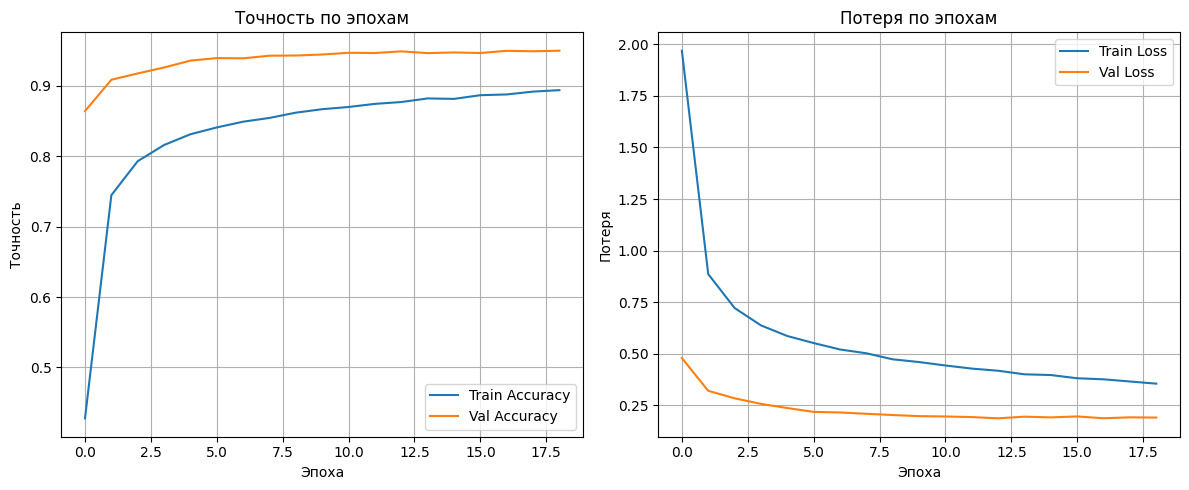

In [37]:
metrics = history.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mfcc_cnn_light.png", dpi=300)
plt.show()

In [38]:
test_mfcc_audio = []
test_mfcc_labels = []

for audio, label in test_mfcc_ds:
  test_mfcc_audio.append(audio.numpy())
  test_mfcc_labels.append(label.numpy())

test_mfcc_audio = np.array(test_mfcc_audio)
test_mfcc_labels = np.array(test_mfcc_labels)

In [39]:
y_pred = np.argmax(model_mfcc_cnn_light.predict(test_mfcc_audio), axis=1)
y_true = test_mfcc_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Точность на тестовом наборе: 95%


In [40]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9432    0.9651    0.9540       172
        bird     0.9880    0.9483    0.9677       174
         cat     0.9709    0.9598    0.9653       174
         dog     0.9709    0.9543    0.9625       175
        down     0.9244    0.9322    0.9283       236
       eight     0.9274    0.9746    0.9504       236
        five     0.9571    0.9449    0.9510       236
        four     0.9701    0.9538    0.9619       238
          go     0.8884    0.8361    0.8615       238
       happy     0.9884    0.9714    0.9798       175
       house     0.9721    0.9943    0.9831       175
        left     0.9574    0.9534    0.9554       236
      marvin     0.9771    0.9771    0.9771       175
        nine     0.9738    0.9409    0.9571       237
          no     0.8800    0.9244    0.9016       238
         off     0.9129    0.9322    0.9224       236
          on     0.9646    0.9198    0.9417       237
         one     0.8625    

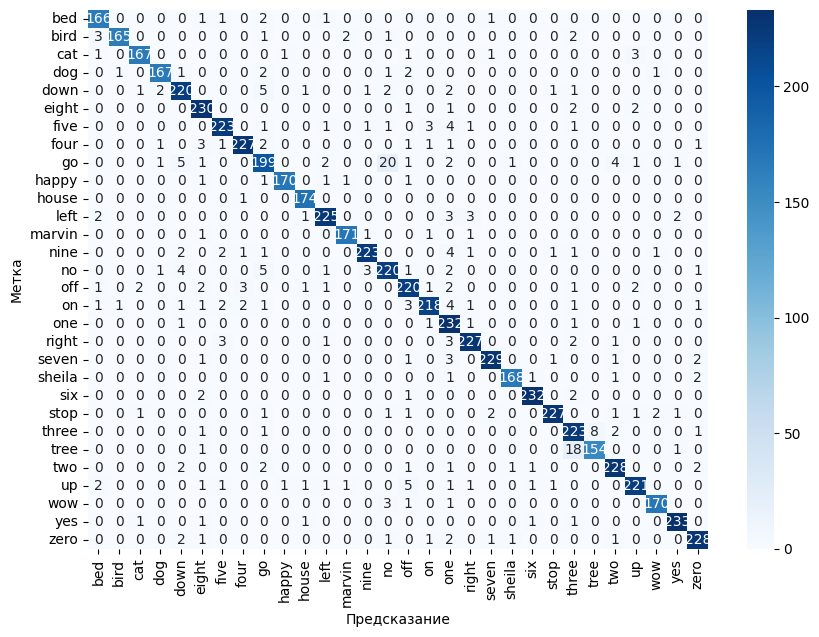

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mfcc_cnn_light.png", dpi=300)
plt.show()

In [42]:
model_mfcc_cnn_light.save("mfcc_cnn_light.keras")

# CNN

In [43]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_mfcc_ds.map(map_func=lambda spec, label: spec))

In [44]:
model_mfcc_cnn = models.Sequential([
    layers.Input(shape=input_mfcc_shape),
    layers.Resizing(64, 64),
    norm_layer,

    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=7, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, kernel_size=9, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels)
])

model_mfcc_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,557,089 (55.53 MB)

 Trainable params: 14,554,590 (55.52 MB)

 Non-trainable params: 2,499 (9.77 KB)

In [45]:
model_mfcc_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [46]:
EPOCHS = 50
history = model_mfcc_cnn.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 165s 172ms/step - accuracy: 0.2792 - loss: 2.7341 - val_accuracy: 0.8333 - val_loss: 0.5765
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 119s 147ms/step - accuracy: 0.7867 - loss: 0.7250 - val_accuracy: 0.9110 - val_loss: 0.2972
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 145ms/step - accuracy: 0.8465 - loss: 0.5227 - val_accuracy: 0.9244 - val_loss: 0.2651
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 145ms/step - accuracy: 0.8726 - loss: 0.4299 - val_accuracy: 0.9413 - val_loss: 0.2068
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.8880 - loss: 0.3739 - val_accuracy: 0.9515 - val_loss: 0.1873
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9023 - loss: 0.3289 - val_accuracy: 0.9470 - val_loss: 0.1858
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9106 - loss: 0.2981 - val_accuracy: 0.9558 - val_loss: 0.1599
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.9178 -

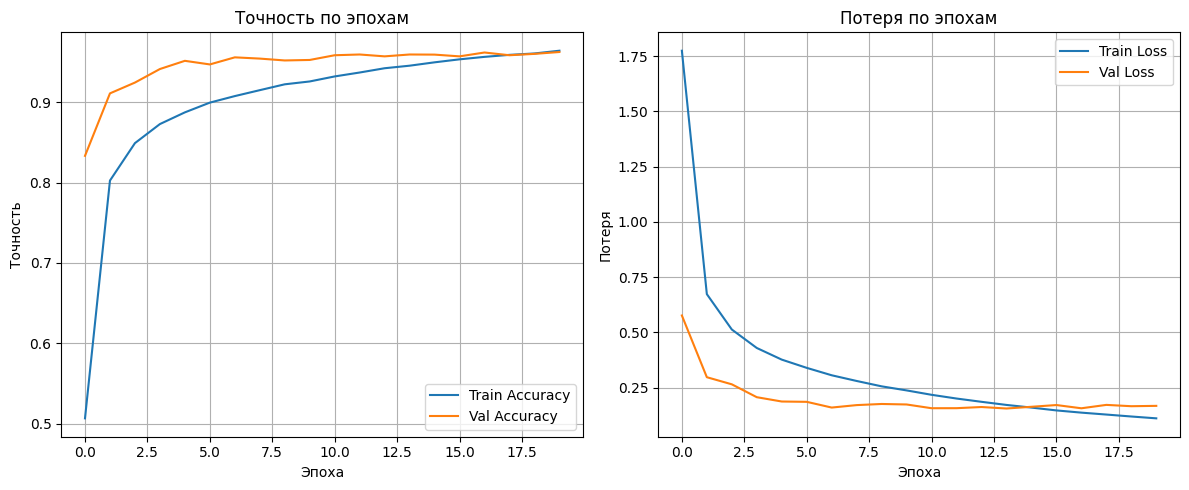

In [47]:
metrics = history.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mfcc_cnn.png", dpi=300)
plt.show()

In [48]:
test_mfcc_audio = []
test_mfcc_labels = []

for audio, label in test_mfcc_ds:
  test_mfcc_audio.append(audio.numpy())
  test_mfcc_labels.append(label.numpy())

test_mfcc_audio = np.array(test_mfcc_audio)
test_mfcc_labels = np.array(test_mfcc_labels)

In [49]:
y_pred = np.argmax(model_mfcc_cnn.predict(test_mfcc_audio), axis=1)
y_true = test_mfcc_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Точность на тестовом наборе: 96%


In [50]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9348    1.0000    0.9663       172
        bird     0.9822    0.9540    0.9679       174
         cat     0.9653    0.9598    0.9625       174
         dog     0.9344    0.9771    0.9553       175
        down     0.9774    0.9153    0.9453       236
       eight     0.9871    0.9703    0.9786       236
        five     0.9781    0.9449    0.9612       236
        four     0.9433    0.9790    0.9608       238
          go     0.9651    0.9286    0.9465       238
       happy     1.0000    0.9714    0.9855       175
       house     0.9943    0.9886    0.9914       175
        left     0.9703    0.9703    0.9703       236
      marvin     1.0000    0.9829    0.9914       175
        nine     0.9657    0.9494    0.9574       237
          no     0.9483    0.9244    0.9362       238
         off     0.9389    0.9110    0.9247       236
          on     0.9692    0.9283    0.9483       237
         one     0.9280    

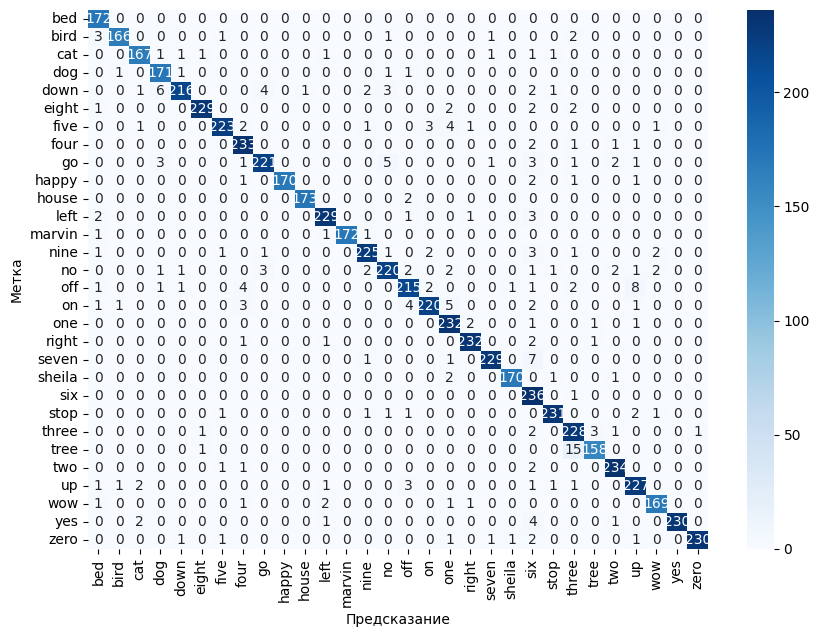

In [51]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mfcc_cnn.png", dpi=300)
plt.show()

In [52]:
model_mfcc_cnn.save("mfcc_cnn.keras")

# TCN

In [53]:
def get_mfcc_and_label_id(audio, label):
    mfcc_features = get_mfcc(audio)
    mfcc_features = tf.squeeze(mfcc_features, axis=-1)
    label_id = tf.argmax(label == commands)
    return mfcc_features, label_id

In [54]:
mfcc_ds = preprocess_mfcc_dataset(train_files)
test_mfcc_ds = preprocess_mfcc_dataset(test_files)

In [55]:
batch_size = 128

train_mfcc_ds = (
    preprocess_mfcc_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_mfcc_ds = (
    preprocess_mfcc_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [56]:
for mfcc, _ in mfcc_ds.take(1):
    input_shape = mfcc.shape
print('Размер входных данных для MFCC:', input_shape)

num_labels = len(commands)

Размер входных данных для MFCC: (98, 13)


In [57]:
norm_layer = layers.Normalization()
norm_layer.adapt(mfcc_ds.map(lambda x, y: x))

In [58]:
model_mfcc_tcn = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    
    layers.Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(256, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Conv1D(256, kernel_size=3, dilation_rate=8, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model_mfcc_tcn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 98, 13)              │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 64)              │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 98, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 98, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 98, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 49, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 49, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 49, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 49, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 24, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 24, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 659,321 (2.52 MB)

 Trainable params: 656,990 (2.51 MB)

 Non-trainable params: 2,331 (9.11 KB)

In [59]:
model_mfcc_tcn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [60]:
EPOCHS = 50
history_tcn = model_mfcc_tcn.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 86s 28ms/step - accuracy: 0.3799 - loss: 2.1580 - val_accuracy: 0.8598 - val_loss: 0.4757
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7943 - loss: 0.6999 - val_accuracy: 0.9025 - val_loss: 0.3268
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8405 - loss: 0.5447 - val_accuracy: 0.9119 - val_loss: 0.3007
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8619 - loss: 0.4733 - val_accuracy: 0.9318 - val_loss: 0.2327
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8740 - loss: 0.4291 - val_accuracy: 0.9362 - val_loss: 0.2262
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8820 - loss: 0.4003 - val_accuracy: 0.9352 - val_loss: 0.2183
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8904 - loss: 0.3739 - val_accuracy: 0.9456 - val_loss: 0.1955
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8934 - loss: 0.3585 - val_acc

In [61]:
model_mfcc_tcn.save("mfcc_tcn.keras")

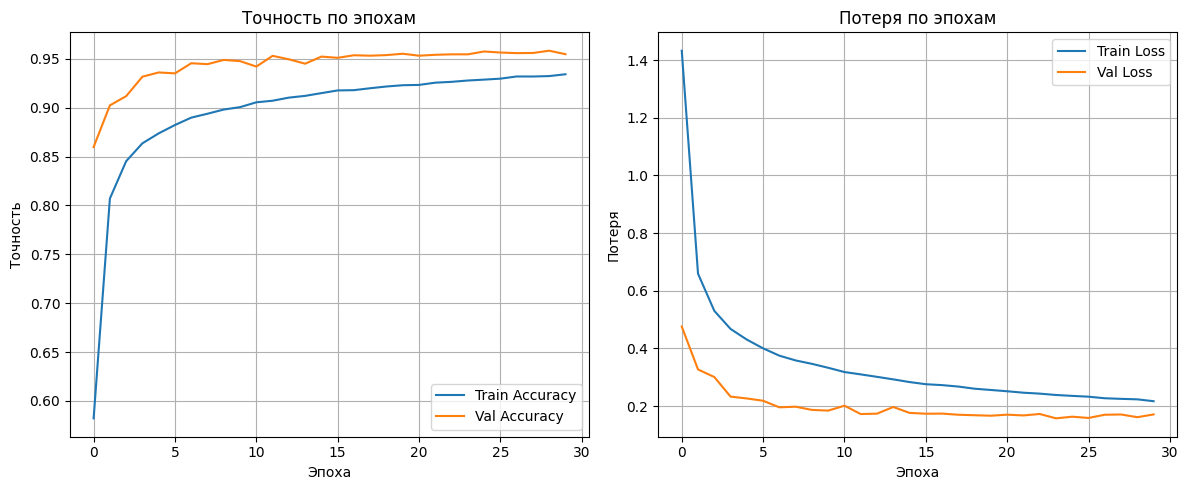

In [62]:
metrics = history_tcn.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_tcn.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_tcn.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_tcn.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_tcn.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mfcc_tcn.png", dpi=300)
plt.show()

In [63]:
test_audio = []
test_labels = []

for audio, label in test_mfcc_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [64]:
y_pred = np.argmax(model_mfcc_tcn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Точность на тестовом наборе: 96%


In [65]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9711    0.9767    0.9739       172
        bird     0.9657    0.9713    0.9685       174
         cat     0.9392    0.9770    0.9577       174
         dog     0.9058    0.9886    0.9454       175
        down     0.9614    0.9492    0.9552       236
       eight     0.9582    0.9703    0.9642       236
        five     0.9620    0.9661    0.9641       236
        four     0.9827    0.9538    0.9680       238
          go     0.9812    0.8782    0.9268       238
       happy     0.9941    0.9600    0.9767       175
       house     0.9830    0.9886    0.9858       175
        left     0.9828    0.9661    0.9744       236
      marvin     1.0000    0.9771    0.9884       175
        nine     0.8726    0.9536    0.9113       237
          no     0.9615    0.9454    0.9534       238
         off     0.8889    0.9492    0.9180       236
          on     0.9651    0.9325    0.9485       237
         one     0.9740    

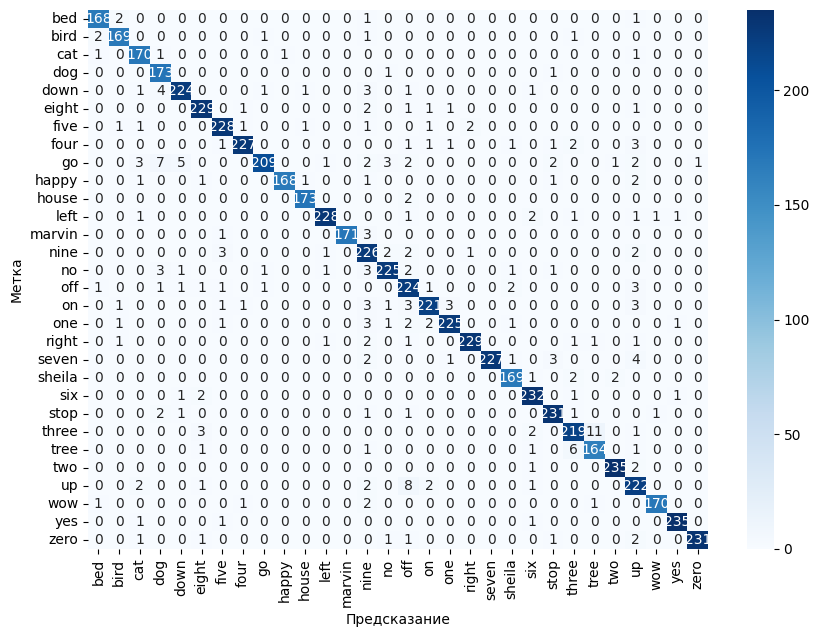

In [66]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mfcc_tcn.png", dpi=300)
plt.show()

# CRNN

In [67]:
def get_mfcc_and_label_id(audio, label):
    mfcc_features = get_mfcc(audio)
    label_id = tf.argmax(label == commands)
    return mfcc_features, label_id

In [68]:
mfcc_ds = preprocess_mfcc_dataset(train_files)
test_mfcc_ds = preprocess_mfcc_dataset(test_files)

In [69]:
batch_size = 128

train_mfcc_ds = (
    preprocess_mfcc_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_mfcc_ds = (
    preprocess_mfcc_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [70]:
for mfcc, _ in mfcc_ds.take(1):
    input_shape = mfcc.shape
print('Размер входных данных для MFCC:', input_shape)

num_labels = len(commands)

Размер входных данных для MFCC: (98, 13, 1)


In [71]:
norm_layer = layers.Normalization()
norm_layer.adapt(mfcc_ds.map(lambda x, y: x))

In [72]:
model_mfcc_crnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,

    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, kernel_size=7, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Reshape((16, 512)),

    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels)
])


model_mfcc_crnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_3 (Normalization)      │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,971,745 (30.41 MB)

 Trainable params: 7,969,246 (30.40 MB)

 Non-trainable params: 2,499 (9.77 KB)

In [73]:
model_mfcc_crnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [74]:
EPOCHS = 150
history_crnn = model_mfcc_crnn.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)

Epoch 1/150


E0000 00:00:1748098182.134286      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_17_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


809/809 ━━━━━━━━━━━━━━━━━━━━ 215s 196ms/step - accuracy: 0.1890 - loss: 2.8642 - val_accuracy: 0.8308 - val_loss: 0.5390
Epoch 2/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 153s 189ms/step - accuracy: 0.7404 - loss: 0.8644 - val_accuracy: 0.8516 - val_loss: 0.5135
Epoch 3/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 153s 189ms/step - accuracy: 0.8157 - loss: 0.6167 - val_accuracy: 0.9108 - val_loss: 0.3007
Epoch 4/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 151s 187ms/step - accuracy: 0.8467 - loss: 0.5124 - val_accuracy: 0.9257 - val_loss: 0.2516
Epoch 5/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 152s 188ms/step - accuracy: 0.8669 - loss: 0.4458 - val_accuracy: 0.9379 - val_loss: 0.2102
Epoch 6/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 152s 188ms/step - accuracy: 0.8833 - loss: 0.3990 - val_accuracy: 0.9425 - val_loss: 0.1927
Epoch 7/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 152s 187ms/step - accuracy: 0.8917 - loss: 0.3609 - val_accuracy: 0.9495 - val_loss: 0.1784
Epoch 8/150
809/809 ━━━━━━━━━━━━━━━━━━━━ 151s 187ms/step - accuracy: 0.9000 - los

In [75]:
model_mfcc_crnn.save("mfcc_crnn.keras")

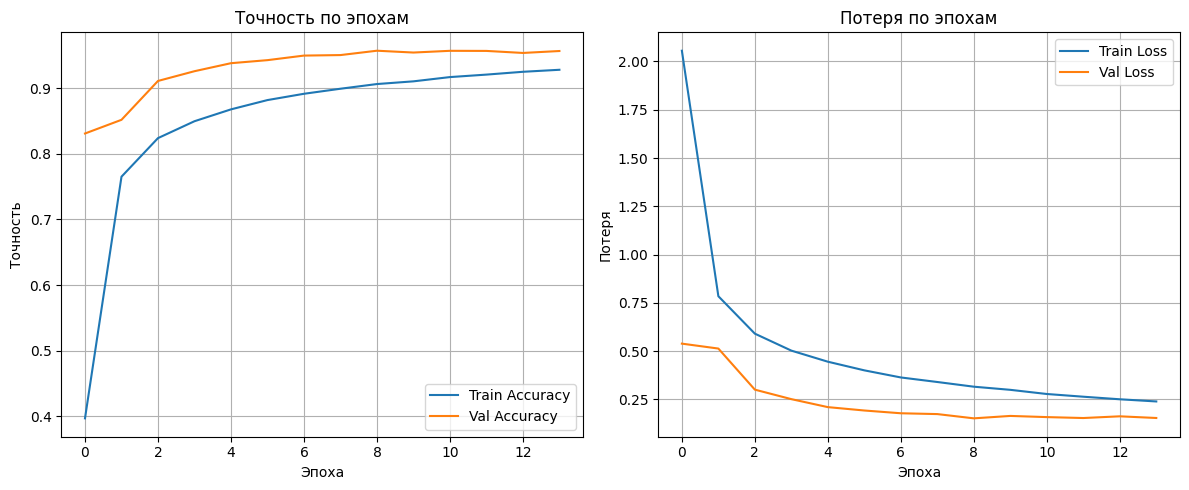

In [76]:
metrics = history_crnn.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_crnn.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_crnn.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_crnn.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_crnn.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_mfcc_crnn.png", dpi=300)
plt.show()

In [77]:
test_audio = []
test_labels = []

for audio, label in test_mfcc_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [78]:
y_pred = np.argmax(model_mfcc_crnn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
Точность на тестовом наборе: 96%


In [79]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9144    0.9942    0.9526       172
        bird     0.9711    0.9655    0.9683       174
         cat     0.9763    0.9483    0.9621       174
         dog     0.9494    0.9657    0.9575       175
        down     0.9524    0.9322    0.9422       236
       eight     0.9664    0.9746    0.9705       236
        five     0.8545    0.9703    0.9087       236
        four     0.9622    0.9622    0.9622       238
          go     0.9079    0.9118    0.9099       238
       happy     1.0000    0.9657    0.9826       175
       house     0.9775    0.9943    0.9858       175
        left     0.9702    0.9661    0.9682       236
      marvin     0.9830    0.9886    0.9858       175
        nine     0.9782    0.9451    0.9614       237
          no     0.9208    0.9286    0.9247       238
         off     0.9513    0.9110    0.9307       236
          on     0.9818    0.9114    0.9453       237
         one     0.9827    

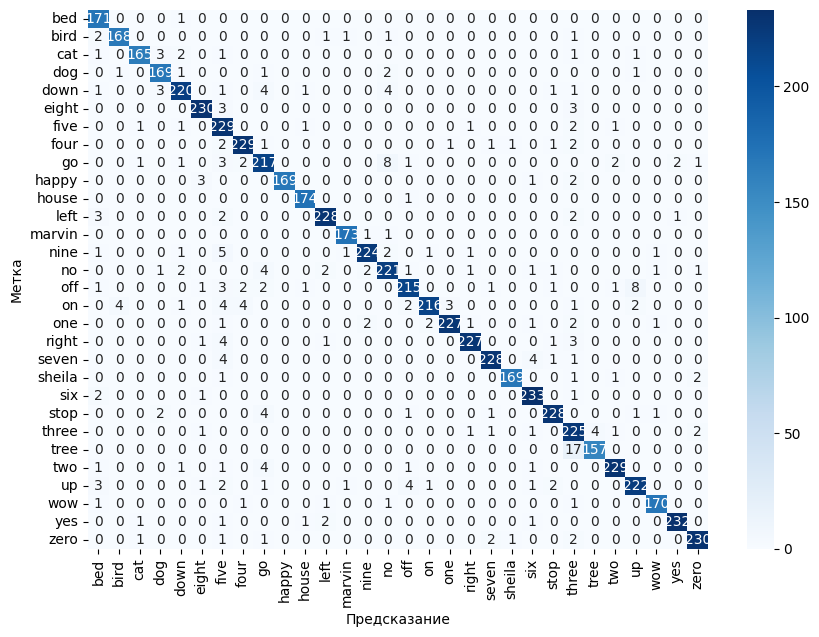

In [80]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_mfcc_crnn.png", dpi=300)
plt.show()